In [110]:
import numpy as np
import pickle
import csv
import torch
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from tools import load, split, estimate_derivative, train, test

In [111]:
file = '1_15_20'
# file = '1_600_20'
cm = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])

data, sequence, times_sec, sequence_sec = load(file, reduced=True)

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec):
    try:
        flag = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i])
    labels[flag] = sequence[i][1]

In [112]:
X = []
Y = []
I = []

for i, t in enumerate(sequence_sec):
    try:
        flags = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flags = (times_sec > sequence_sec[i])
    sample = data[flags][:18]
    t_sample = times_sec[flags][:18]

    x0 = sample[0, :]
    t0 = t_sample[0]
    int = np.zeros((sample.shape[1]))
    for k in range(1, sample.shape[0]):
        dif = np.abs(sample[k, :] - x0)/(t_sample[k] - t0)
        int += dif
    if len(sample.flatten()) == 144:
        X.append(sample)
        Y.append(sequence[i][1]-1)
        I.append(int)

X = np.array(X)
Y = np.array(Y)
I = np.array(I)

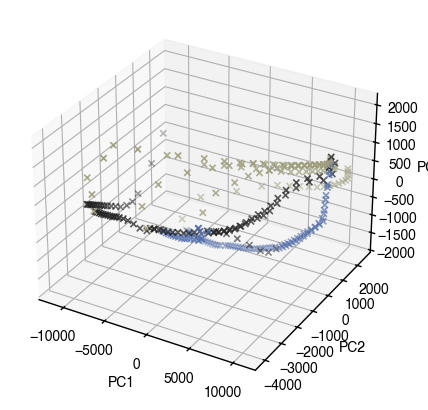

In [122]:
n_frames = 1000

flags = labels > 0
flags = flags[:n_frames]
names = ['Ethylene', 'Carbon monoxide', 'Methane', 'Ethylene + Carbon monoxide', 'Methane + Carbon monoxide', 'Ethylene + Methane']

pca = PCA(n_components=3)
pca.fit(data)
transform = pca.transform(data)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transform[flags,0], transform[flags,1], transform[flags,2],
           c=labels[flags],
           cmap=cm,
           marker='x',
           )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

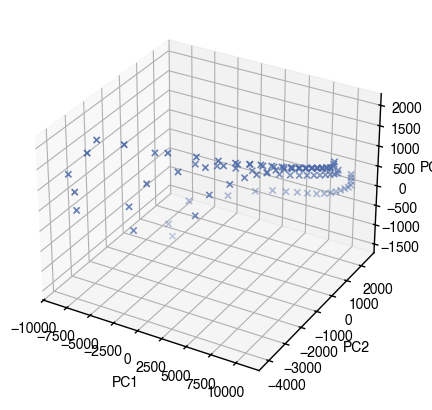

In [114]:
flags = labels == 2
flags = flags[:n_frames]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transform[flags,0], transform[flags,1], transform[flags,2],
           c=labels[:n_frames][flags],
           cmap=cm,
           marker='x',
           )
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

/var/folders/w2/znr__42x45s1rjb1hj583bbr0000gn/T/ipykernel_23312/1670293473.py:19: UserWarning: Adding colorbar to a different Figure <Figure size 1000x500 with 2 Axes> than <Figure size 1000x500 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(lc, ax=ax, shrink=0.7, pad=0.1)


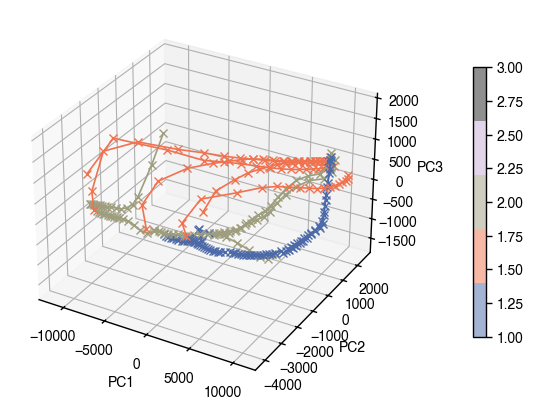

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

flags = (labels > 0)[:n_frames]
idx = np.flatnonzero(flags)

pts = transform[idx]                 # (N, 3)
lbl = labels[:n_frames][idx]         # (N,) label per point


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')

for i, sample in enumerate(X):
    pts = pca.transform(sample)
    ax.plot(pts[:,0], pts[:,1], pts[:,2], c=cm(Y[i]),  marker='x')

fig.colorbar(lc, ax=ax, shrink=0.7, pad=0.1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

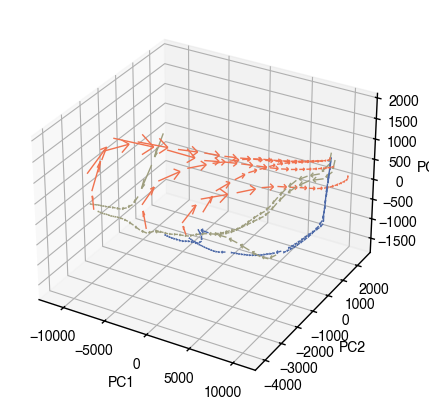

In [116]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')

for i, sample in enumerate(X):
    pts = pca.transform(sample)              # (T, 3)
    color = cm(Y[i])

    # line + markers
    # ax.plot(pts[:,0], pts[:,1], pts[:,2], c=color, marker='x')

    # arrows from point t -> t+1
    d = pts[1:] - pts[:-1]                   # (T-1, 3) direction vectors
    ax.quiver(
        pts[:-1,0], pts[:-1,1], pts[:-1,2],  # start points
        d[:,0], d[:,1], d[:,2],              # vector components
        color=color,
        pivot='tail',
        # normalize=True,
        length=0.75,
        arrow_length_ratio=0.3,              # tweak arrowhead size
        linewidth=1.,
        # linewidth=1,
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()


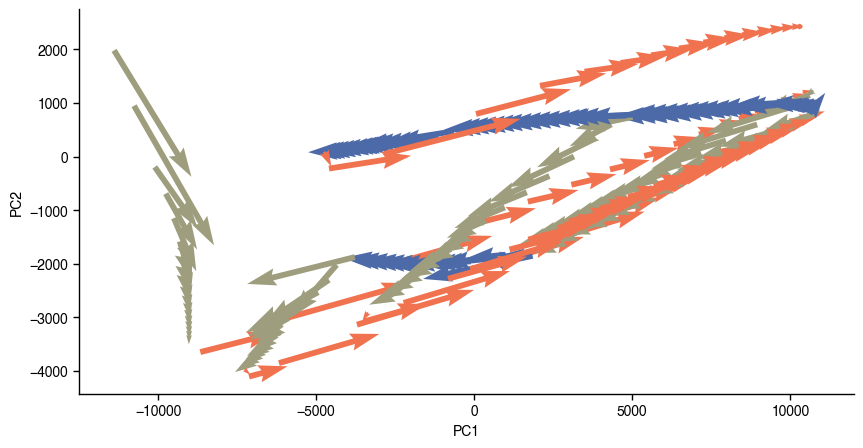

In [120]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

for i, sample in enumerate(X):
    pts = pca.transform(sample)              # (T, 3)
    color = cm(Y[i])

    # line + markers
    # ax.plot(pts[:,0], pts[:,1], pts[:,2], c=color, marker='x')

    # arrows from point t -> t+1
    d = pts[1:] - pts[:-1]                   # (T-1, 3) direction vectors
    ax.quiver(
        pts[:-1,0], pts[:-1,1],  # start points
        d[:,0], d[:,1],              # vector components
        color=color,
        pivot='tail',
        # normalize=True,
        # length=0.75,
        # arrow_length_ratio=0.3,              # tweak arrowhead size
        linewidth=1.,
        # linewidth=1,
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
plt.show()
